# unsupervided learning ex.2


In [26]:
import numpy as np
from numpy.testing import assert_allclose

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from my_lib import *

#plt.style.use('ggplot')

# load data

In [27]:
#Load Dataset
features = ["F"+str(x) for x in range(1,11,1)]
data: pd.DataFrame = pd.read_csv("data_kPCA.txt", sep = " ", 
                                header = None, 
                                names  = features, 
                                index_col = False)
obs = data.shape[0]
dims = data.shape[1]
print(f'shape: {obs} observations, {dims} features')
labels: pd.DataFrame = pd.read_csv("labels_kPCA.txt",  
                                header = None, 
                                names  = ["labels"], 
                                index_col = False)
labels["labels"].value_counts()

shape: 10000 observations, 10 features


0    2500
1    2500
2    2500
3    2500
Name: labels, dtype: int64

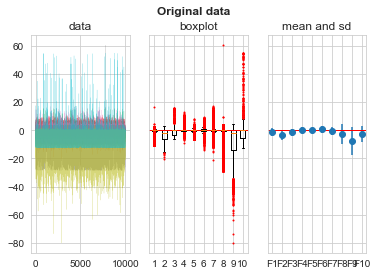

In [28]:
def plot_data_mean_sd(features:list, data, title):
    import matplotlib.pyplot as plt
    mm, sd = np.mean(data, axis = 0), np.std (data, axis = 0)

    flierprops = dict(marker='o',  markersize=1,
                  linestyle='none',
                  markeredgecolor='r',markerfacecolor='r')
    
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
    ax0.plot(data,linewidth=.2, alpha = .6)
    ax0.set_title("data")
    ax1.boxplot(data, flierprops=flierprops)
    ax1.set_title('boxplot')
    ax1.axhline(y=0, color='r', linestyle='-', linewidth=1)
    
    ax2.errorbar(features, mm, sd, linestyle='None', marker='o')
    ax2.set_title('mean and sd')
    ax2.axhline(y=0, color='r', linestyle='-', linewidth=1)


    fig.suptitle(title, fontweight ="bold")
    
plot_data_mean_sd(features, data,  "Original data")  


In [29]:
some_features = pd.DataFrame(data.iloc[:,:4])
some_features = pd.concat((some_features, labels), 1)
sns.set_style("whitegrid")
sns.pairplot(some_features,hue = 'labels')
plt.show()


# Preprocess: center and scale

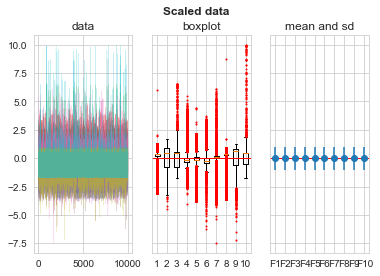

In [ ]:
#normalize data 
mm, sd = np.mean(data, axis = 0), np.std (data, axis = 0)
X= (data  - mm)/sd   

#check
assert_allclose (np.mean(X, axis = 0), 0,  atol=1e-9) , "mean should be 0"
assert_allclose (np.std (X, axis = 0), 1,  atol=1e-9) , "sd should be 1"

plot_data_mean_sd(features, X, "Scaled data")  


# Transform

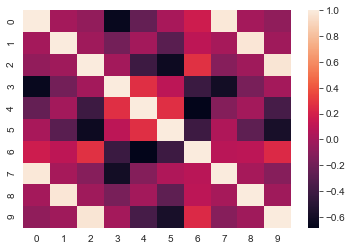

In [ ]:
## covariance matrix
cov_mat = np.cov(X, rowvar = False)
sns.heatmap(cov_mat)
#Coviariance matrix is symmetric, diagional elements == 1
nnn = len(features)
for i in range(nnn):
    for j in range(nnn-i):
        assert cov_mat[i,j] == cov_mat[j,i]
        if i == j:
            assert_allclose (cov_mat[i,j], 1,atol=1e-4 )

In [ ]:
# calculaye eigenvalues eigenvectors using numpy
eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)
sorted_index = np.argsort(eigen_values)[::-1] #[::-1] descending order
sorted_eigenvalues = eigen_values[sorted_index]
sorted_eigenvectors = eigen_vectors[:,sorted_index]
 

In [ ]:
#save eigenvalues and eigenvectors in a dataframe
eigen = pd.DataFrame(columns = ['val', 'vect'])
eigen.val = eigen_values
nn = len(features)

for i,row in eigen.iterrows():
    eigen.at[i, 'vect'] = eigen_vectors[i,:nn]
    
eigen = eigen.sort_values(by='val', ascending = False)
eigen['explained_variance'] = eigen['val'].cumsum()/eigen['val'].sum()
eigen['pc'] = 'PC'+(nn-eigen.index).astype(str)
eigen.reset_index(drop = True, inplace = True)
eigen = eigen[['pc','val', 'vect', 'explained_variance' ]]
eigen.head(5)



,pc,val,vect,explained_variance
0,PC1,3.129258,"[0.016809903816575582, 0.10543190370830055, 0....",0.312895
1,PC2,2.623246,"[-0.018980724543694788, 0.6859479347000726, -0...",0.575193
2,PC3,2.026035,"[-0.6783738089636319, -0.032991788205660955, 0...",0.777776
3,PC4,1.062863,"[0.02564074197274943, -0.0232190500592164, -0....",0.884052
4,PC5,0.511072,"[0.004790955138401868, -0.049265921798880896, ...",0.935154


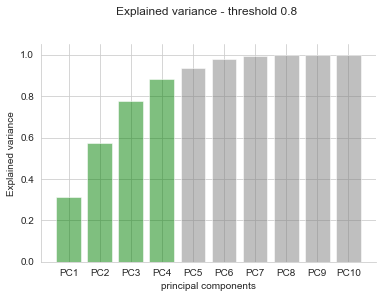

In [ ]:
#set a variance threshold to change color on the bar chart
variance_threshold = .8
brk = eigen[eigen.explained_variance > variance_threshold].index[1]

#explained variance chart
fig, ax = plt.subplots()

#ax = plt.plot(eigen.pc, eigen.explained_variance,  color='black', alpha = .5)
plt.bar(eigen.pc[:brk], eigen.explained_variance[:brk], color='green', alpha = .5)
plt.bar(eigen.pc[brk:], eigen.explained_variance[brk:], color='gray', alpha = .5)

plt.title(f'Explained variance - threshold {variance_threshold} \n\n')
plt.xlabel('principal components')
plt.ylabel('Explained variance')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)



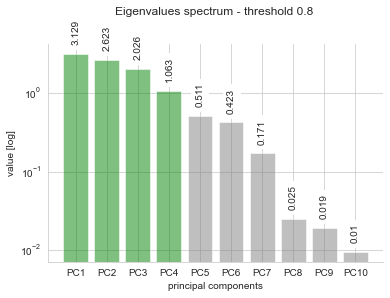

In [ ]:
#set a variance threshold to change color on the spectrum bar chart
#variance_threshold = .9
brk = eigen[eigen.explained_variance > variance_threshold].index[1]


#eigenvalue spectrum log scale
fig, ax = plt.subplots()
cols = ['green']*brk+['gray']*(nn-brk)
bar_plot = plt.bar(eigen.pc, eigen.val,   color = cols, alpha = .5)
plt.title(f'Eigenvalues spectrum - threshold {variance_threshold} \n\n')
plt.xlabel('principal components')
plt.ylabel('value [log]')
plt.yscale("log")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
bar_label = eigen.val.round(decimals = 3).to_list()
for idx,rect in enumerate(bar_plot):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.3*height,
            bar_label[idx],backgroundcolor="w",
            ha='center', va='bottom', rotation=90)




## transform

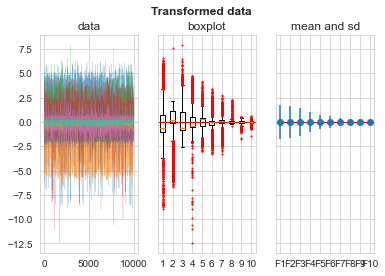

In [ ]:
a = sorted_eigenvectors.transpose()
b = X.transpose()
X_pc = np.dot(a,b).transpose()
plot_data_mean_sd(features, X_pc, "Transformed data")  


# reduce dimensions

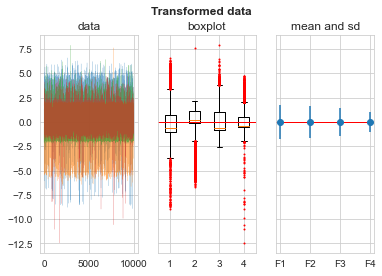

In [ ]:
#select only PC that explain 90% of variance
limit = .5
d = eigen[eigen.explained_variance > variance_threshold].index[1]

#reduce to d components
X_pc_r = X_pc[:,:d]
ff = features[:d]
plot_data_mean_sd(ff, X_pc_r, "Transformed data")  



In [ ]:
# reduce the dataframe
index_to_drop = eigen[ eigen.explained_variance > variance_threshold ].index[1:]
eigen_r = eigen.drop(index = index_to_drop)
eigen_r

,pc,val,vect,explained_variance
0,PC1,3.129258,"[0.016809903816575582, 0.10543190370830055, 0....",0.312895
1,PC2,2.623246,"[-0.018980724543694788, 0.6859479347000726, -0...",0.575193
2,PC3,2.026035,"[-0.6783738089636319, -0.032991788205660955, 0...",0.777776
3,PC4,1.062863,"[0.02564074197274943, -0.0232190500592164, -0....",0.884052


In [ ]:
X_pc_df = pd.DataFrame(X_pc_r)
X_pc_df = pd.concat((X_pc_df, labels), 1)


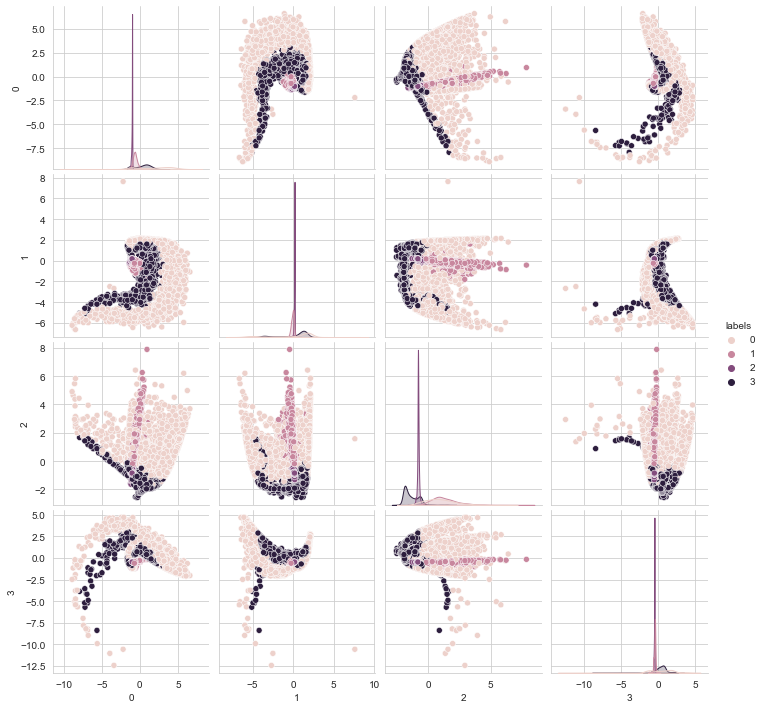

In [ ]:

sns.set_style("whitegrid")
sns.pairplot(X_pc_df,hue = 'labels')
plt.show()


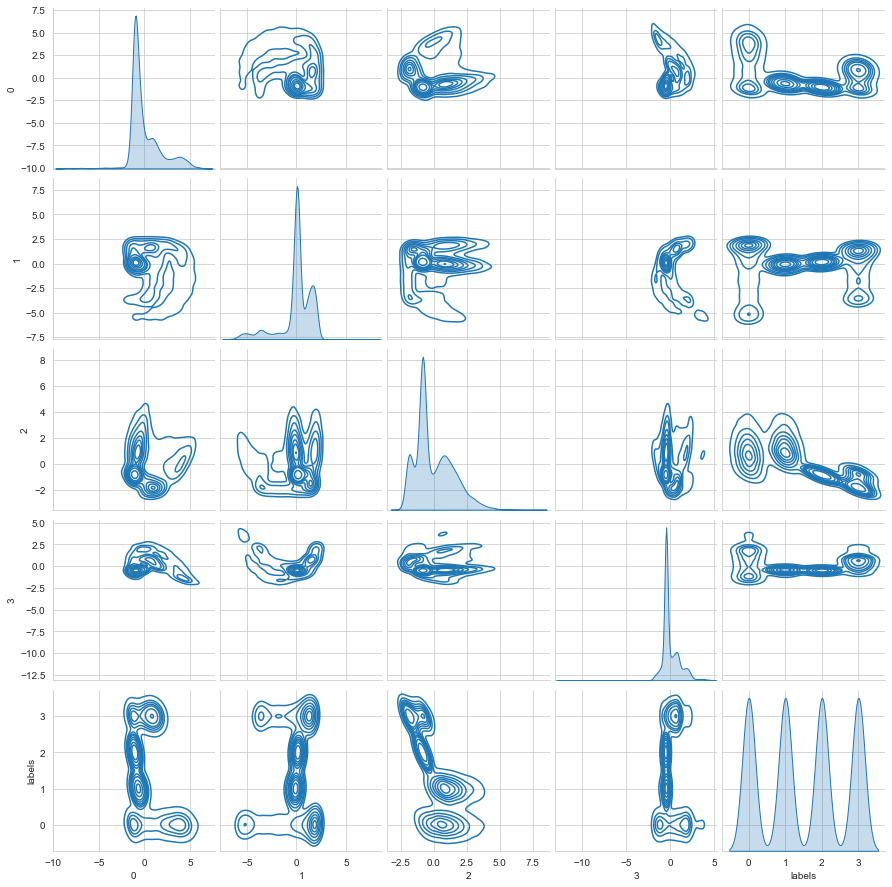

In [ ]:
sns.set_style("whitegrid")
sns.pairplot(X_pc_df,hue='labels', kind='kde')
plt.show()

##https://seaborn.pydata.org/generated/seaborn.pairplot.html

# Divide test and learning dataset

In [ ]:
#Divide test (first 1000 points) and learning (other 9000 points)
test=X_pc_r[:1000]
learn = X_pc_r[1000:]
test.shape, learn.shape



((1000, 4), (9000, 4))

#TODO multivariate regression